In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

import sys
sys.path.append("../")

# functions
from src.evaluation.evaluation_metrics import print_evaluation_metrics, plot_roc_curve, plot_heatmap_confusion_matrix

from imblearn.over_sampling import SMOTE

# Preprocessing
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder,
)
from src.preprocessing.agg_invoice import (
    agg_invoice_num_mode_no_monthly_weighting,
    agg_invoice_num_mode_monthly_weighting,
)
from src.preprocessing.cleaning import convert_dtype_cat_date

# Modeling
from xgboost import XGBClassifier

from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder

from matplotlib.ticker import PercentFormatter

plt.rcParams.update(
    {"figure.figsize": (8, 5), "axes.facecolor": "white", "axes.edgecolor": "black"}
)
plt.rcParams["figure.facecolor"] = "w"
pd.plotting.register_matplotlib_converters()
pd.set_option("display.float_format", lambda x: "%.3f" % x)


# Define a plotting style to be used for all plots in this notebook
plt.style.use("tableau-colorblind10")

In [2]:
with open('../data/data_ready_for_models_smart_agg.pkl', 'rb') as f:
    data = pickle.load(f)

In [3]:
data.keys()
print("def")

def


In [4]:
X_train, X_test, y_train, y_test, df_combined, df_combined_encoded, X_train_resampled, y_train_resampled = data.values()

In [5]:
X_train.columns.value_counts()

counter_statue_1          2
counter_statue_4          2
counter_statue_5          2
counter_code_102.0        1
counter_code_303.0        1
                         ..
region_310                1
region_309                1
region_308                1
region_307                1
reading_remarque_413.0    1
Name: count, Length: 104, dtype: int64

In [6]:
#drop columns which are twice in the dataset
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]


In [7]:
# modeling with XGBOOST

xg_boost_model = XGBClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
)
xg_boost_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

---------------------------------------------------------------------------
Confusion Matrix: 
 [[25546    40]
 [ 1483    30]]
---------------------------------------------------------------------------
Accuracy : 
 94.37986641573491
---------------------------------------------------------------------------
Report : 
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     25586
         1.0       0.43      0.02      0.04      1513

    accuracy                           0.94     27099
   macro avg       0.69      0.51      0.50     27099
weighted avg       0.92      0.94      0.92     27099

---------------------------------------------------------------------------
ROC-AUC: 
 0.789581954440654


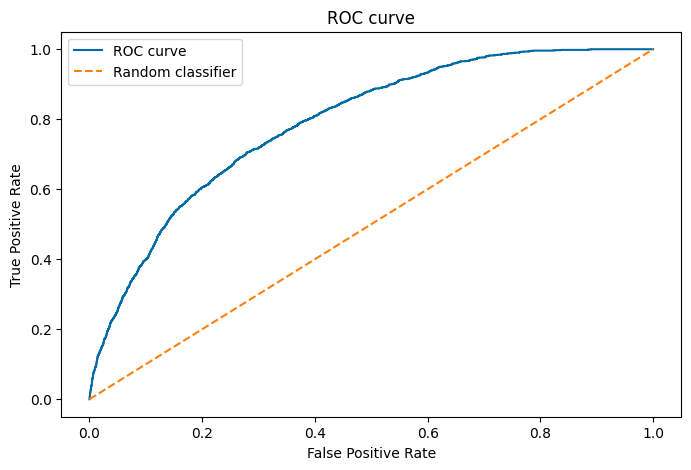

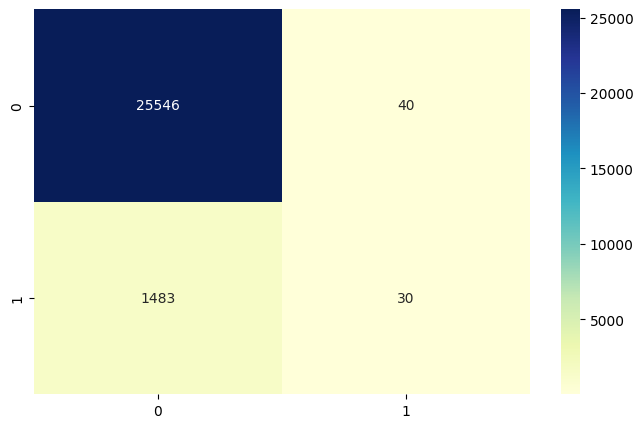

In [8]:
y_train_pred = xg_boost_model.predict(X_train)
y_test_pred = xg_boost_model.predict(X_test)

y_train_pred_proba = xg_boost_model.predict_proba(X_train)
y_test_pred_proba = xg_boost_model.predict_proba(X_test)

'''print_evaluation_metrics(y_train, y_train_pred, y_train_pred_proba)
plot_roc_curve(y_train, y_train_pred_proba)
plot_heatmap_confusion_matrix(y_train, y_train_pred)'''

print_evaluation_metrics(y_test, y_test_pred, y_test_pred_proba)
plot_roc_curve(y_test, y_test_pred_proba)
plot_heatmap_confusion_matrix(y_test, y_test_pred)

### Random Search for Best Parameters for XGBoost

In [9]:
from sklearn.model_selection import RandomizedSearchCV


params = {"n_estimators": list(range(5,100)),
          "learning_rate":list(np.linspace(0.1,1,10)),               
          #"max_depth": [None]+list(range(3,30))
          }

# Instantiate random search and define the metric to optimize 
rs = RandomizedSearchCV(XGBClassifier(), params, scoring='roc_auc',
                   verbose=5, n_jobs=-1, n_iter=5, random_state=10)

In [10]:
rs.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END learning_rate=0.2, n_estimators=35;, score=0.781 total time=  17.6s
[CV 2/5] END learning_rate=0.2, n_estimators=35;, score=0.778 total time=  18.8s
[CV 3/5] END learning_rate=0.2, n_estimators=35;, score=0.780 total time=  18.8s
[CV 4/5] END learning_rate=0.2, n_estimators=35;, score=0.781 total time=  22.0s
[CV 5/5] END learning_rate=0.2, n_estimators=35;, score=0.776 total time=  22.7s
[CV 2/5] END learning_rate=0.30000000000000004, n_estimators=80;, score=0.775 total time=  43.4s
[CV 5/5] END learning_rate=0.30000000000000004, n_estimators=80;, score=0.771 total time=  43.6s
[CV 1/5] END learning_rate=0.30000000000000004, n_estimators=80;, score=0.781 total time=  44.5s
[CV 3/5] END learning_rate=0.30000000000000004, n_estimators=80;, score=0.786 total time=  44.6s
[CV 4/5] END learning_rate=0.30000000000000004, n_estimators=80;, score=0.781 total time=  44.9s
[CV 1/5] END learning_rate=0.6, n_estimators=57;, 

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2,
                                                          0.30000000000000004,
                                                          0.4, 0.5, 0.6,
                                                          0.7000000000000001,
                                                          0.8, 0.9, 1.0],
                                        'n_estimators': [5, 6, 7, 8, 9, 10, 11,
                                                         12, 13, 14, 15, 16, 17,
                                                         18, 19, 20, 21, 22, 23,
                                                         24, 25, 26, 27, 28, 29,
                                                         30, 31, 32, 33, 34, ...]},
                   random_state=10, scoring='roc_auc', verbose=5)

---------------------------------------------------------------------------
Confusion Matrix: 
 [[25584     2]
 [ 1510     3]]
---------------------------------------------------------------------------
Accuracy : 
 94.42045831949518
---------------------------------------------------------------------------
Report : 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     25586
         1.0       0.60      0.00      0.00      1513

    accuracy                           0.94     27099
   macro avg       0.77      0.50      0.49     27099
weighted avg       0.93      0.94      0.92     27099

---------------------------------------------------------------------------
ROC-AUC: 
 0.7854951968166249


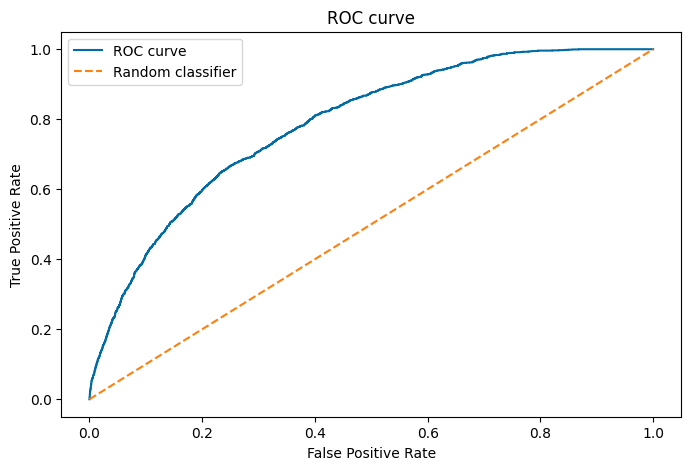

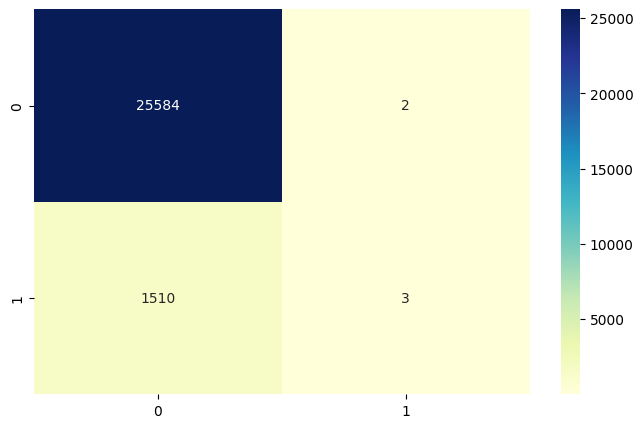

In [11]:
best_boost = rs.best_estimator_

#
y_test_pred = best_boost.predict(X_test)
y_test_pred_proba = best_boost.predict_proba(X_test)
print_evaluation_metrics(y_test, y_test_pred, y_test_pred_proba)
plot_roc_curve(y_test, y_test_pred_proba)
plot_heatmap_confusion_matrix(y_test, y_test_pred)

In [12]:
# summarize results
print("Best: %f using %s" % (rs.best_score_, rs.best_params_))
means = rs.cv_results_['mean_test_score']
stds = rs.cv_results_['std_test_score']
params = rs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))




Best: 0.779270 using {'n_estimators': 35, 'learning_rate': 0.2}
0.778809 (0.005093) with: {'n_estimators': 80, 'learning_rate': 0.30000000000000004}
0.779270 (0.002118) with: {'n_estimators': 35, 'learning_rate': 0.2}
0.758650 (0.006340) with: {'n_estimators': 57, 'learning_rate': 0.6}
0.777340 (0.003588) with: {'n_estimators': 40, 'learning_rate': 0.4}
0.769668 (0.005449) with: {'n_estimators': 89, 'learning_rate': 0.4}


In [13]:
from sklearn.model_selection import GridSearchCV


n_estimators = list(range(5,100,10))
learning_rate = [0.0001, 0.001, 0.01, 0.1]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

gs_first = GridSearchCV(XGBClassifier(), param_grid, scoring='roc_auc', n_jobs=-1, cv=3, verbose=5)
gs_first.fit(X_train, y_train)


Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3] END learning_rate=0.0001, n_estimators=5;, score=0.732 total time=   3.9s
[CV 2/3] END learning_rate=0.0001, n_estimators=5;, score=0.735 total time=   3.9s
[CV 3/3] END learning_rate=0.0001, n_estimators=5;, score=0.739 total time=   3.9s
[CV 1/3] END learning_rate=0.0001, n_estimators=15;, score=0.732 total time=   8.8s
[CV 2/3] END learning_rate=0.0001, n_estimators=15;, score=0.734 total time=   9.5s
[CV 3/3] END learning_rate=0.0001, n_estimators=15;, score=0.739 total time=   9.9s
[CV 1/3] END learning_rate=0.0001, n_estimators=25;, score=0.732 total time=  14.2s
[CV 2/3] END learning_rate=0.0001, n_estimators=25;, score=0.734 total time=  14.9s
[CV 3/3] END learning_rate=0.0001, n_estimators=25;, score=0.739 total time=  15.2s
[CV 1/3] END learning_rate=0.0001, n_estimators=35;, score=0.732 total time=  22.0s
[CV 2/3] END learning_rate=0.0001, n_estimators=35;, score=0.734 total time=  22.0s
[CV 3/3] END lear

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                         'n_estimators': [5, 15, 25, 35, 45, 55, 65, 75, 85,
                                          95]},
             scoring='roc_auc', verbose=5)

Best: 0.781567 using {'learning_rate': 0.1, 'n_estimators': 95}
0.735157 (0.002868) with: {'learning_rate': 0.0001, 'n_estimators': 5}
0.734978 (0.002923) with: {'learning_rate': 0.0001, 'n_estimators': 15}
0.734972 (0.002939) with: {'learning_rate': 0.0001, 'n_estimators': 25}
0.735004 (0.002903) with: {'learning_rate': 0.0001, 'n_estimators': 35}
0.734979 (0.002933) with: {'learning_rate': 0.0001, 'n_estimators': 45}
0.735030 (0.003024) with: {'learning_rate': 0.0001, 'n_estimators': 55}
0.735416 (0.003307) with: {'learning_rate': 0.0001, 'n_estimators': 65}
0.735513 (0.003429) with: {'learning_rate': 0.0001, 'n_estimators': 75}
0.735538 (0.003404) with: {'learning_rate': 0.0001, 'n_estimators': 85}
0.735620 (0.003553) with: {'learning_rate': 0.0001, 'n_estimators': 95}
0.734978 (0.002931) with: {'learning_rate': 0.001, 'n_estimators': 5}
0.735932 (0.003954) with: {'learning_rate': 0.001, 'n_estimators': 15}
0.737659 (0.003310) with: {'learning_rate': 0.001, 'n_estimators': 25}
0.738

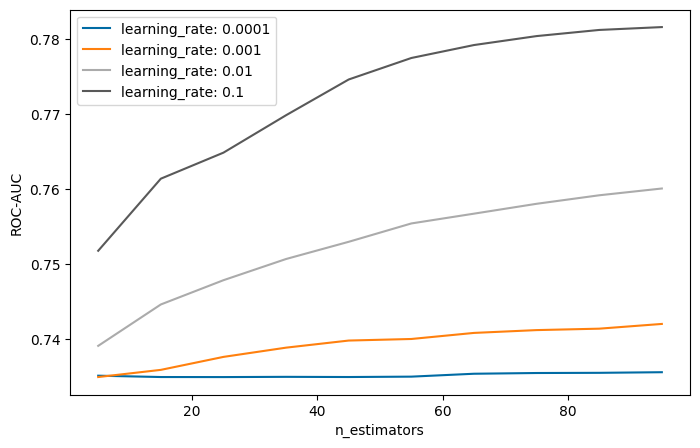

In [15]:
# summarize results
print("Best: %f using %s" % (gs_first.best_score_, gs_first.best_params_))
means = gs_first.cv_results_['mean_test_score']
stds = gs_first.cv_results_['std_test_score']
params = gs_first.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))


# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.show()

In [17]:
gs_first.best_params_

{'learning_rate': 0.1, 'n_estimators': 95}

---------------------------------------------------------------------------
Confusion Matrix: 
 [[25581     5]
 [ 1503    10]]
---------------------------------------------------------------------------
Accuracy : 
 94.43521901177165
---------------------------------------------------------------------------
Report : 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     25586
         1.0       0.67      0.01      0.01      1513

    accuracy                           0.94     27099
   macro avg       0.81      0.50      0.49     27099
weighted avg       0.93      0.94      0.92     27099

---------------------------------------------------------------------------
ROC-AUC: 
 0.7903420363364817


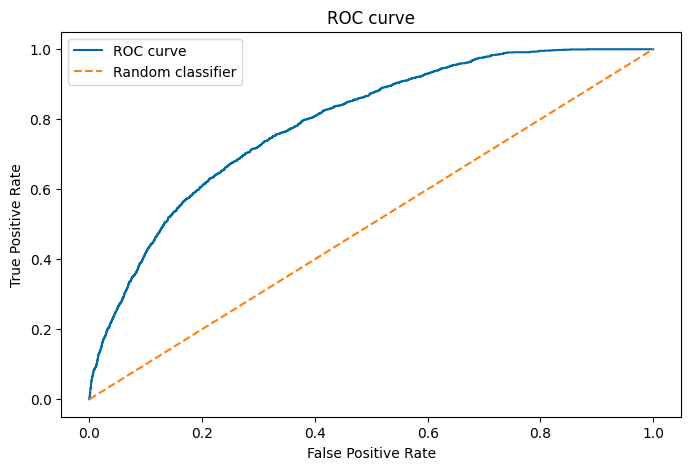

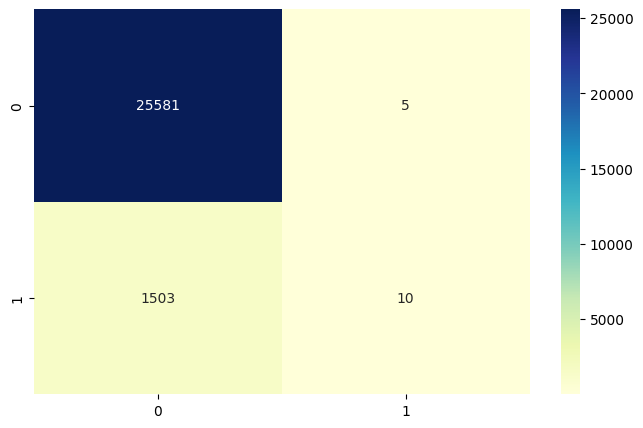

In [19]:
best_boost = gs_first.best_estimator_

#
y_test_pred = best_boost.predict(X_test)
y_test_pred_proba = best_boost.predict_proba(X_test)
print_evaluation_metrics(y_test, y_test_pred, y_test_pred_proba)
plot_roc_curve(y_test, y_test_pred_proba)
plot_heatmap_confusion_matrix(y_test, y_test_pred)

In [20]:

n_estimators = list(range(20,150,5))
learning_rate = list(np.linspace(0.1,1,10))
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

gs = GridSearchCV(XGBClassifier(), param_grid, scoring='roc_auc', n_jobs=-1, cv=3, verbose=5)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 260 candidates, totalling 780 fits
[CV 2/3] END learning_rate=0.1, n_estimators=20;, score=0.764 total time=   9.8s
[CV 3/3] END learning_rate=0.1, n_estimators=20;, score=0.761 total time=  10.2s
[CV 1/3] END learning_rate=0.1, n_estimators=20;, score=0.763 total time=  10.5s
[CV 1/3] END learning_rate=0.1, n_estimators=25;, score=0.765 total time=  12.3s
[CV 2/3] END learning_rate=0.1, n_estimators=25;, score=0.766 total time=  12.5s
[CV 3/3] END learning_rate=0.1, n_estimators=25;, score=0.764 total time=  12.6s
[CV 1/3] END learning_rate=0.1, n_estimators=30;, score=0.768 total time=  14.8s
[CV 2/3] END learning_rate=0.1, n_estimators=30;, score=0.768 total time=  15.2s
[CV 3/3] END learning_rate=0.1, n_estimators=30;, score=0.767 total time=  15.3s
[CV 1/3] END learning_rate=0.1, n_estimators=35;, score=0.770 total time=  17.0s
[CV 2/3] END learning_rate=0.1, n_estimators=35;, score=0.771 total time=  17.1s
[CV 3/3] END learning_rate=0.1, n_estimators=3

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.30000000000000004, 0.4,
                                           0.5, 0.6, 0.7000000000000001, 0.8,
                                           0.9, 1.0],
                         'n_estimators': [20, 25, 30, 35, 40, 45, 50, 55, 60,
                                          65, 70, 75, 80, 85, 90, 95, 100, 105,
                                          110, 115, 120, 125, 130, 135, 140,
                                          145]},
             scoring='roc_auc', verbose=5)

Best: 0.782580 using {'learning_rate': 0.1, 'n_estimators': 130}
0.762677 (0.001347) with: {'learning_rate': 0.1, 'n_estimators': 20}
0.764851 (0.000893) with: {'learning_rate': 0.1, 'n_estimators': 25}
0.767439 (0.000515) with: {'learning_rate': 0.1, 'n_estimators': 30}
0.769834 (0.000724) with: {'learning_rate': 0.1, 'n_estimators': 35}
0.772326 (0.001065) with: {'learning_rate': 0.1, 'n_estimators': 40}
0.774591 (0.000843) with: {'learning_rate': 0.1, 'n_estimators': 45}
0.776227 (0.001081) with: {'learning_rate': 0.1, 'n_estimators': 50}
0.777452 (0.001189) with: {'learning_rate': 0.1, 'n_estimators': 55}
0.778350 (0.001123) with: {'learning_rate': 0.1, 'n_estimators': 60}
0.779176 (0.001447) with: {'learning_rate': 0.1, 'n_estimators': 65}
0.779530 (0.001480) with: {'learning_rate': 0.1, 'n_estimators': 70}
0.780369 (0.001326) with: {'learning_rate': 0.1, 'n_estimators': 75}
0.780705 (0.001298) with: {'learning_rate': 0.1, 'n_estimators': 80}
0.781186 (0.001234) with: {'learning_r

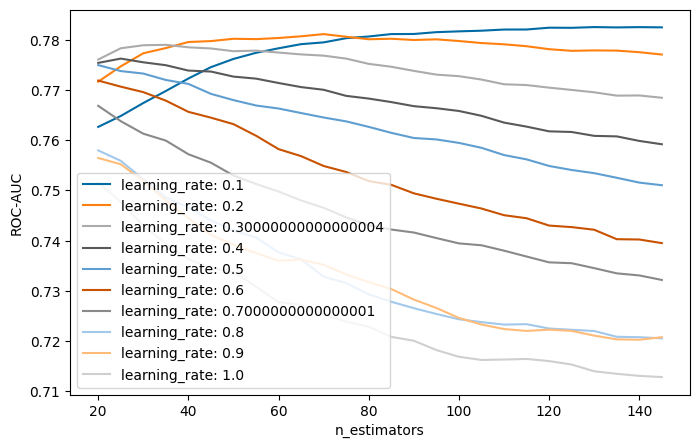

In [21]:
# summarize results
print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
params = gs.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))


# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.show()

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=130, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)>
---------------------------------------------------------------------------
Confusion Matrix: 
 [[25577     9]
 [ 1504     9]]
---------------------------------------------------------------------------
Accuracy

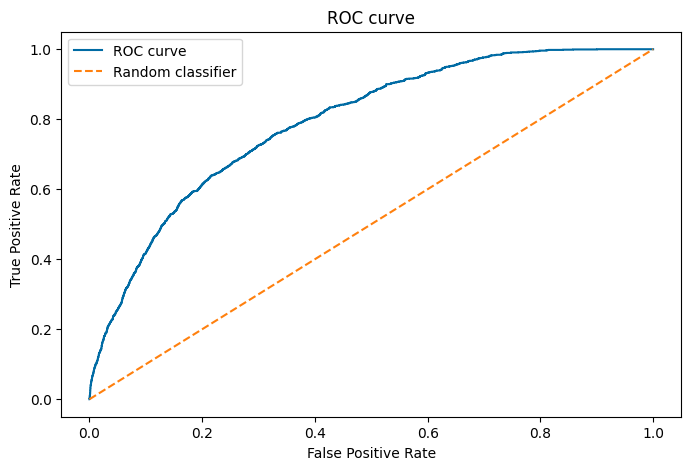

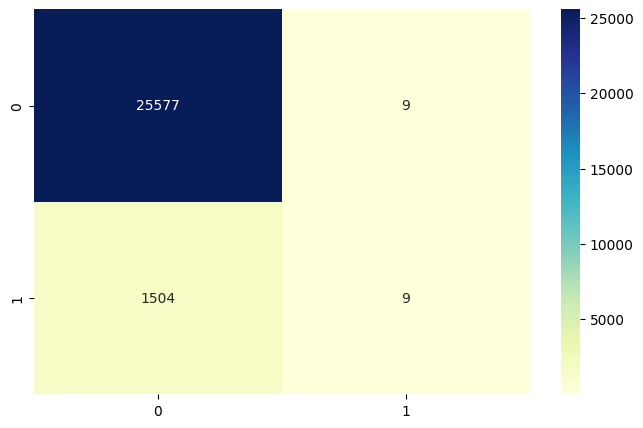

In [22]:
best_boost = gs.best_estimator_
print(best_boost.get_params)
#
y_test_pred = best_boost.predict(X_test)
y_test_pred_proba = best_boost.predict_proba(X_test)
print_evaluation_metrics(y_test, y_test_pred, y_test_pred_proba)
plot_roc_curve(y_test, y_test_pred_proba)
plot_heatmap_confusion_matrix(y_test, y_test_pred)


<Axes: title={'center': 'Feature Importance'}, xlabel='features'>

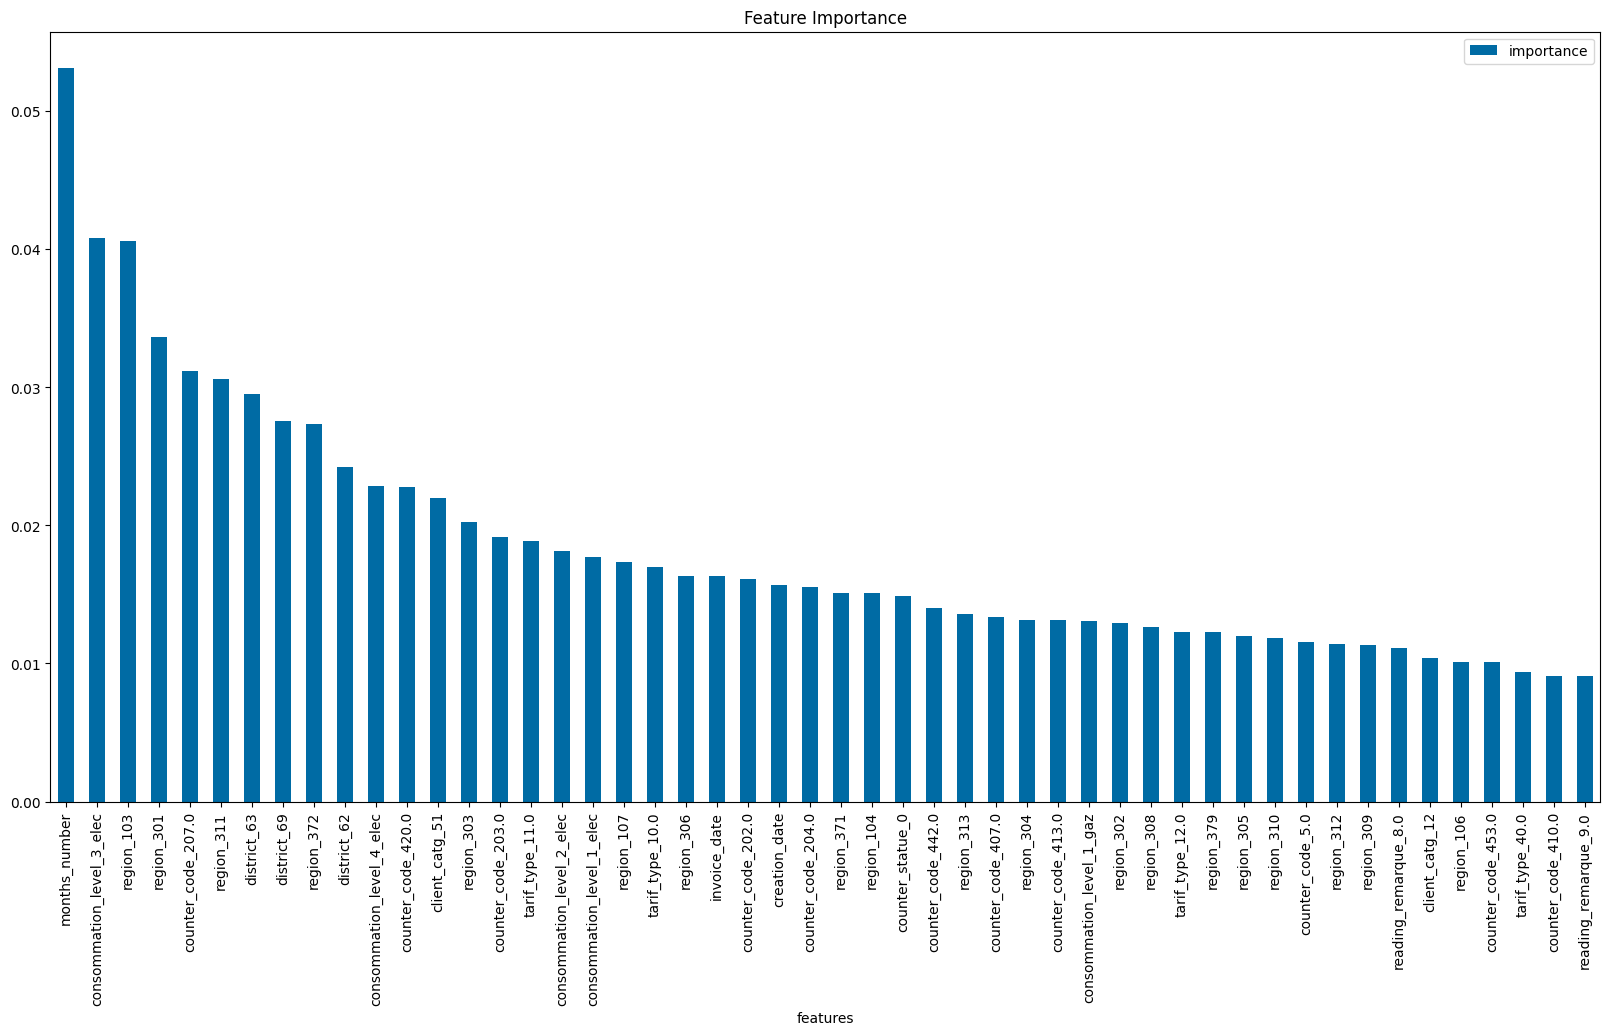

In [35]:
best_boost.feature_importances_

df_fi= pd.DataFrame({"features": X_train.columns, "importance": best_boost.feature_importances_}).sort_values(by="importance", ascending=False).head(50)
print(df_fi.h
df_fi.plot.bar(x="features", y="importance", rot=90, title="Feature Importance", figsize=(20,10))

In [23]:

n_estimators = list(range(15,120,5))
learning_rate = list(np.linspace(0.15,0.5,10))
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)

gs_n = GridSearchCV(XGBClassifier(), param_grid, scoring='roc_auc', n_jobs=-1, cv=3, verbose=5)
gs_n.fit(X_train, y_train)

Fitting 3 folds for each of 210 candidates, totalling 630 fits
[CV 2/3] END learning_rate=0.15, n_estimators=15;, score=0.764 total time=   9.7s
[CV 1/3] END learning_rate=0.15, n_estimators=15;, score=0.765 total time=   9.9s
[CV 3/3] END learning_rate=0.15, n_estimators=15;, score=0.760 total time=   9.9s
[CV 2/3] END learning_rate=0.15, n_estimators=20;, score=0.768 total time=  12.4s
[CV 3/3] END learning_rate=0.15, n_estimators=20;, score=0.765 total time=  12.7s
[CV 1/3] END learning_rate=0.15, n_estimators=20;, score=0.769 total time=  13.0s
[CV 1/3] END learning_rate=0.15, n_estimators=25;, score=0.771 total time=  15.4s
[CV 2/3] END learning_rate=0.15, n_estimators=25;, score=0.772 total time=  15.5s
[CV 3/3] END learning_rate=0.15, n_estimators=25;, score=0.769 total time=  15.9s
[CV 1/3] END learning_rate=0.15, n_estimators=30;, score=0.773 total time=  18.8s
[CV 2/3] END learning_rate=0.15, n_estimators=30;, score=0.776 total time=  19.4s
[CV 3/3] END learning_rate=0.15, n_

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.15, 0.18888888888888888,
                                           0.22777777777777777,
                                           0.26666666666666666,
                                           0.3055555555555556,
                                           0.34444444444444444,
                                           0.3833333333333333,
                                           0.4222222222222223,
                                           0.46111111111111114, 0.5],
                         'n_estimators': [15, 20, 25, 30, 35, 40, 45, 50, 55,
                                          60, 65, 70, 75, 80, 85, 90, 95, 100,
                                          105, 110, 115]},
             scoring='roc_auc', verbose=5)

Best: 0.781708 using {'learning_rate': 0.22777777777777777, 'n_estimators': 60}
0.762738 (0.002185) with: {'learning_rate': 0.15, 'n_estimators': 15}
0.767182 (0.001355) with: {'learning_rate': 0.15, 'n_estimators': 20}
0.770515 (0.001343) with: {'learning_rate': 0.15, 'n_estimators': 25}
0.773570 (0.001714) with: {'learning_rate': 0.15, 'n_estimators': 30}
0.776199 (0.001350) with: {'learning_rate': 0.15, 'n_estimators': 35}
0.777246 (0.002186) with: {'learning_rate': 0.15, 'n_estimators': 40}
0.778663 (0.001644) with: {'learning_rate': 0.15, 'n_estimators': 45}
0.778795 (0.001631) with: {'learning_rate': 0.15, 'n_estimators': 50}
0.779548 (0.001220) with: {'learning_rate': 0.15, 'n_estimators': 55}
0.779814 (0.000973) with: {'learning_rate': 0.15, 'n_estimators': 60}
0.780198 (0.001158) with: {'learning_rate': 0.15, 'n_estimators': 65}
0.780427 (0.001266) with: {'learning_rate': 0.15, 'n_estimators': 70}
0.780512 (0.001301) with: {'learning_rate': 0.15, 'n_estimators': 75}
0.780727 (

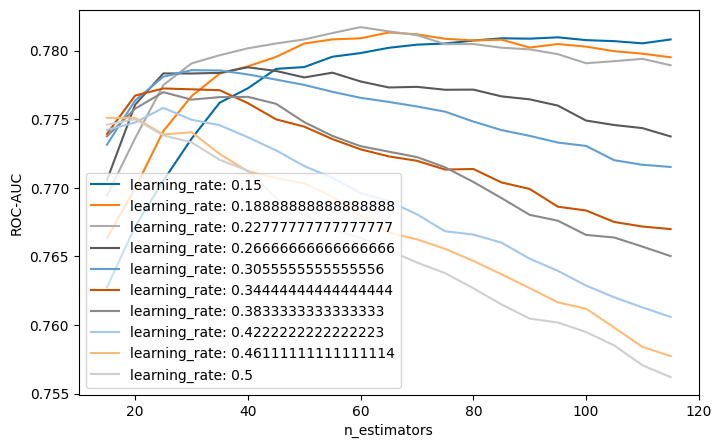

In [24]:
# summarize results
print("Best: %f using %s" % (gs_n.best_score_, gs_n.best_params_))
means = gs_n.cv_results_['mean_test_score']
stds = gs_n.cv_results_['std_test_score']
params = gs_n.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
 print("%f (%f) with: %r" % (mean, stdev, param))


# plot results
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC')
plt.show()

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.22777777777777777,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=60, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)>
---------------------------------------------------------------------------
Confusion Matrix: 
 [[25564    22]
 [ 1496    17]]
---------------------------------------------------------------------

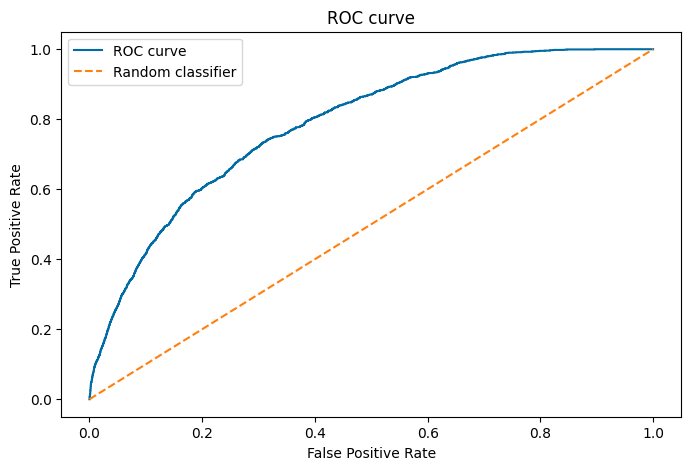

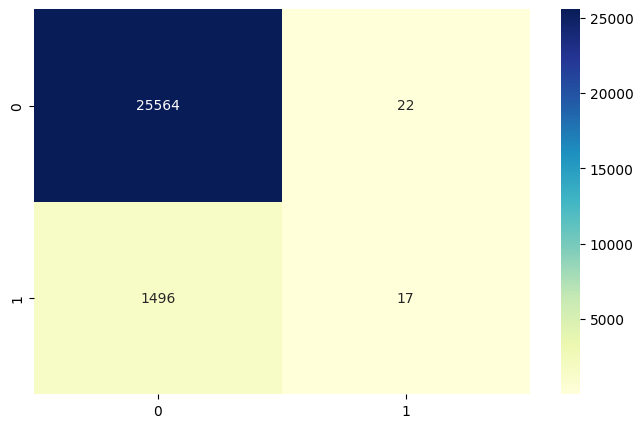

In [25]:
best_boost_n = gs_n.best_estimator_
print(best_boost_n.get_params)
#
y_test_pred = best_boost_n.predict(X_test)
y_test_pred_proba = best_boost_n.predict_proba(X_test)
print_evaluation_metrics(y_test, y_test_pred, y_test_pred_proba)
plot_roc_curve(y_test, y_test_pred_proba)
plot_heatmap_confusion_matrix(y_test, y_test_pred)


In [26]:
#save results as pickle:
best_gs = gs
sec_best_gs = gs_n

data={"best_gs" : best_gs,
      "sec_best_gs": sec_best_gs, 
      "best_boost": best_boost
      }

with open('../models/xgboost/xgboost_grid_raw_smart_agg.pkl', 'wb') as f:
    pickle.dump(data,f)


,creation_date,months_number,invoice_date,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,district_62,district_63,...,counter_code_506.0,counter_code_532.0,counter_code_565.0,counter_code_600.0,reading_remarque_7.0,reading_remarque_8.0,reading_remarque_9.0,reading_remarque_203.0,reading_remarque_413.0,counter_type_GAZ
client_id,,,,,,,,,,,,,,,,,,,,,
train_Client_46032,1451001600000000000,3.636,1513877236363636480,1.000,161.812,43.288,65.463,129.325,False,False,...,False,False,False,False,False,False,True,False,False,False
train_Client_8884,1289606400000000000,4.000,1331436342857142784,1.000,119.536,49.911,0.000,0.000,False,False,...,False,False,False,False,False,False,False,False,False,False
train_Client_80860,1225152000000000000,4.194,1389334296774193664,1.000,98.692,0.000,0.000,0.000,False,False,...,False,False,False,False,False,False,False,False,False,False
train_Client_21716,467856000000000000,4.542,1384837200000000000,1.000,105.156,0.000,0.000,0.000,False,False,...,False,False,False,False,False,False,True,False,False,False
train_Client_95171,606700800000000000,3.877,1379907692307692288,1.000,66.548,0.000,0.000,0.000,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_Client_107750,879984000000000000,4.000,1343085942857142784,1.000,249.786,53.714,6.018,0.000,True,False,...,False,False,False,False,False,False,False,False,False,False
train_Client_59063,897436800000000000,3.731,1364120597014925312,1.000,79.760,0.000,0.000,0.000,False,False,...,False,False,False,False,False,False,False,False,False,False
train_Client_68496,1215820800000000000,3.882,1392145411764705792,1.000,107.015,0.000,0.000,0.000,False,False,...,False,False,False,False,False,False,False,False,False,False
